<a href="https://colab.research.google.com/github/CabeludoCego/SistEvolutivos/blob/main/Enviado_AAC5_NSGA_Refeito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as U
import math
import time

# Funções: Min-Ex

In [ ]:
def f1(x1):
  return x1

def f2(x1,x2):
  return ((1+x2)/x1)

def fitnessMO(vt_real, Fit, pop):
  for i in range(pop):
    Fit[i,0] = f1(vt_real[i][0])
    Fit[i,1] = f2(vt_real[i][0], vt_real[i][1])

def Dominando(Fit, vRank, pop):
  for i in range(pop):
    Fi1 = Fit[i,0]
    Fi2 = Fit[i,1]
    ni = 0
    for k in range(pop):
      if ((Fi1) > Fit[k,0]):    # Se é pior que um objetivo E
        if ((Fi2) > Fit[k,1]):  # Se é pior que o segundo objetivo
          ni += 1             # É dominada
    vRank[i] = ni + 1         # Atribui um rank


def Fdist(x,y, xmax, xmin):
  d = 0
  a = 0
  for i in range(nx):
    a += ( ( (x[i] - y[i])/(xmax[i] - xmin[i]) )**2)
  d = np.sqrt(a)
  return d

def nicho(d, alfaShare, alfa):
  if d <= alfaShare:
    f = 1 - (d/alfaShare)**alfa
  else:
    f = 0
  return f

In [ ]:
def sortir(vetor, vetorIndices, elementos):
  indices = (np.argsort(vetorIndices, axis=0))
  n = len(vetor[0])
  vetorSortido = np.zeros((elementos,n))
  i = 0
  while i < elementos:
    vetorSortido[i] = vetor[int(indices[i])]
    i = i + 1
  return vetorSortido

def sortirMaior(vetor, vetorIndices, elementos):
  indices = (np.argsort(vetorIndices, axis=0))
  n = len(vetor[0])
  vetorSortido = np.zeros((elementos,n))
  i = 0
  while i < elementos:
    vetorSortido[i] = vetor[int(indices[i])]
    i = i + 1
  return vetorSortido[::-1]

In [ ]:
# Etapa 3: Obter número total de ranks
def rankMembers(vRank_s):
  r_count = []    # Se não existe no vetor, anexa a ele
  for i in vRank_s:
    if (i not in r_count): r_count.append(i)  

  numRanks = len(r_count)

  memberCount = np.zeros((numRanks,2), dtype=int)

  Elem_contados = []
  n = 0
  for i in vRank_s:
    if i not in Elem_contados:
      Elem_contados.append(i)  # Anexado à lista de ranks únicos
      memberCount[n,0] = i
      memberCount[n,1] = list(vRank_s).count(i)
      n += 1

  return memberCount

In [ ]:
def Fitness_NSGA(vt_real_s, vRank_s, memberCount, limXY ,pop):
  dmatrix = np.zeros((pop,pop), dtype=float)
  nichomat = np.ones((pop,pop), dtype=float)
  nichoC = np.ones((pop,1), dtype=float)

  FitComp = pop*np.ones((pop,1))
  thisRank_Fit = F_min - epsilon

  for r in (memberCount[:,0]):
    # r = rankAtual
    for i in range(pop):          # Contador de posição
      if (vRank_s[i] == r):       # Confere se é o mesmo rank
        for k in range(pop):      # Coleta outro elemento
          if (i != k and (vRank_s[i] == vRank_s[k])): # Impede 1 com 1 e verifica outros do rank
            d = 0
            X1 = [vt_real_s[i,0],vt_real_s[i,1]]
            X2 = [vt_real_s[k,0],vt_real_s[k,1]] 
            d = Fdist(X1, X2, limXY[1], limXY[0])
            dmatrix[i,k] = d
            nichomat[i,k] = nicho(d,alfaShare,alfa)
            nichoC[i] += nichomat[i,k]  
          # Calcular a Fitness compartilhada
        FitComp[i] = thisRank_Fit/nichoC[i]
        #print(FitComp[i])
      # Antes de incrementar para o próximo rank:
    Fmin = np.min(FitComp)
    thisRank_Fit = Fmin - epsilon
    #print(thisRank_Fit)

  return FitComp

In [ ]:
def bin2real(b, xmin, xmax):
  # Conversão de inteiro para binário
  s = 0
  n = len(b)        # [s1,l] => Pega a dimensão 2
  for l in range(n):
    s = s + b[l]*pow(2,l)
  return xmin + (xmax - xmin)*s/(pow(2,n)-1)

In [ ]:
# Criar divisor de bits a serem usados!
def xj_range(bits, nx):
  limites_xj = np.zeros((2,nx), dtype=int)
  cont = 0
  ik = bits
  while ik <= (bits*nx):
    
    if ((ik) % bits == 0):    # Se ik for divisível por 20
      
      limites_xj[1,cont] = ik-1  # Atribui ub: 20, 40, 60, 80 (-1)
      cont = cont + 1            # incrementa
      if (cont < nx):
        limites_xj[0,cont] = ik # Atribui lb: 20, 40, 60 (-1)
      
    ik = ik + 1
  return limites_xj

In [ ]:
xj_range(20, 4)

array([[ 0, 20, 40, 60],
       [19, 39, 59, 79]])

In [ ]:
# Dividir X em nx parcelas de acordo com o limite em Xj_range
# Supondo X = vt[i,:]

def xj_divide(X, bits, nx):
  limites = xj_range(bits,nx)

  Xt = np.zeros((nx,bits), dtype=int)
  i = 0
  for i in range (nx):
    Xt[i,:] = X[limites[0,i]:(limites[1,i]+1)]
                                    # -> [0:19], python pega do 0 ao 18.
                                    # O +1 resolve o problema
  return Xt

In [ ]:
def criarpop(vetor, pop, cromo):
  i = 0
  for i in range(pop):                 # Cria-se uma linha(indivíduo) por vez
    n = (np.random.rand(1,cromo))      # Vetor randômico de números entre 0 e 1
    nr = np.around(n, 0)               # Arrendondam-se entre 0 e 1
    vetor[i,:] = nr[:]  

In [ ]:
def Bin_xyzw_Real(vetor_bin, vetor_real, pop, xmin, xmax):
  for i in range(pop):
    Xj = vetor_bin[i,:]              # Extrai um individuo da pop
    Xj_r = xj_divide(Xj, bits, nx)  # Leva para dividir nas N componentes dela (x,y,z,w)
                            # Passa cada componente para valor real
    Xj_r = np.transpose(Xj_r)
    k = 0
    for k in range (nx):
      vetor_real[i,k] = bin2real(Xj_r[:,k], xmin[k], xmax[k])

In [ ]:
def torneio(Fit_Especial,k):
  # Especial: Escalonada, compartilhada
  melhor_fitness = -1
  vencedor = -1
  for i in range(k):
    competidor = U.randint(0,len(Fit_Especial)-1)
    if Fit_Especial[competidor] > melhor_fitness:
      melhor_fitness = Fit_Especial[competidor]
      vencedor = competidor
  return vencedor

In [ ]:
# Deprecado. Esconde os vetor_sortido do código.

def NSGA(modo):
  print('Problema: ' + modo)
  Dominando(Fit, vRank, pop)
 
  vRank_s = sortir(vRank, vRank, pop)
  vt_real_s = sortir(vt_real, vRank, pop)
  vt_bin_s = sortir(vt_bin, vRank, pop)
  Fit_s = sortir(Fit, vRank, pop)

  # Etapa 1: Número de ranks e membros por rank
  memberCount = rankMembers(vRank_s)

  FitComp = Fitness_NSGA(vt_real_s, vRank_s, memberCount, limXY , pop)
  return [FitComp, memberCount]

In [ ]:
def selecao_maximizar(FitComp, pop):
  i_selecionados = np.zeros((pop,1), dtype=int)
  for k in range(pop):
    i_selecionados[k] = torneio(FitComp, 3)
  return i_selecionados

In [ ]:
def criaPares(pop, indicesSelec):
  vetor_pares = np.zeros((pop,2), dtype=int) # Indices dos pares 
  for p in range(pop):   # Preencher todos os filhos
    for k in range(2):              # Escolher 2 dos selecionados de forma randomica
      r = int(np.floor(pop*(U.random())))
      vetor_pares[p,k] = indicesSelec[r]
  return vetor_pares

In [ ]:
def cruzamentoUmPonto(P_1, P_2, Filho):  # Crossover de 1 ponto
  # Gerar máscara
  m = int(np.floor(cromo*U.random()))   # Gera num entre 0 e cromo
  Filho[0:m] = P_1[0:m]
  Filho[m:cromo] = P_2[m:cromo]

  return Filho

In [ ]:
def cruzamento(vetor_bin_S, indice_pares, filhos, Px):
  for i in range(pop):
    r = U.random()  # Porcentagem de crossover
    if (r <= Px):
      P_1 = vetor_bin_S[indice_pares[i,0]]
      P_2 = vetor_bin_S[indice_pares[i,1]]
      filhos[i,:] = cruzamentoUmPonto(P_1, P_2, filhos[i,:])
    else:
      filhos[i,:] = vetor_bin_S[indice_pares[i,0]]
  # Se não tiver crossover, ele simplesmente deixa o filho como estava.

In [ ]:
# Taxa de mutação: Pm = 0.02
def mutacao(filho, cromo, Pm):
  for i in range(cromo):
    r = U.random()    # Porcentagem de crossover
    if (r < Pm):     
      filho[i] = int(not filho[i]) # Inversão com porta NOT, depois converte pra int
  return filho

# Loop - NSGA binario p/ Min-Ex

In [ ]:
# Parâmetros AG bin
pop = 60
MaxGen = 300
filhospop = int(pop*0.8)
doupop = int(pop*2)
bits = 40
nx = 2
cromo = bits*nx
Px = 0.95
Pm = 0.02

limXY =  [[0.1, 0],    # X, Y   # Min
          [1  , 5]]             # Max
xmin = limXY[0]
xmax = limXY[1]

# Criação de vetores
vt_bin = np.zeros((pop, cromo), dtype=int)
vt_real = np.zeros((pop, nx), dtype=float)
Fit = np.zeros((pop,2))
vRank = np.zeros((pop,1), dtype=int)

filhos = np.zeros((pop, cromo), dtype=int)
fi_real = np.zeros((pop, nx), dtype=float)
fi_Fit = np.zeros((pop,2))
fi_Rank = np.zeros((pop,1), dtype=int)


dmatrix = np.zeros((pop,pop), dtype=float)
nichomat = np.ones((pop,pop), dtype=float)
nichoC = np.ones((pop,1), dtype=float)

In [ ]:
# Parâmetros NSGA
alfa = 2
alfaShare = 0.12
epsilon = 0.1
F_min = pop + epsilon

# Inicialização
criarpop(vt_bin, pop, cromo)
print(vt_bin[0:3,:])


# Conversão em Real e Cálculo de Fitness
Bin_xyzw_Real(vt_bin, vt_real, pop, xmin, xmax)

# Calculo da fit

fitnessMO(vt_real, Fit, pop)

print(Fit[0:3,:])

[[0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1
  0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0
  1 0 0 0 0 0 0 1]
 [0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0
  1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 0
  0 1 1 0 0 1 0 1]
 [0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0
  1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0
  1 1 1 1 1 0 1 1]]
[[ 0.69473989  5.07421428]
 [ 0.50655931  8.38944212]
 [ 0.51991873 10.31936281]]


In [ ]:
#MaxGen = 300
# Temos vt_bin inicializado
for i in range(MaxGen):
  
  ### Fitness dos valores Reais
  Bin_xyzw_Real(vt_bin, vt_real, pop, xmin, xmax)
  fitnessMO(vt_real, Fit, pop)
  Dominando(Fit, vRank, pop)

  vRank_s = sortir(vRank, vRank, pop)
  vt_real_s = sortir(vt_real, vRank, pop)
  vt_bin_s = sortir(vt_bin, vRank, pop)
  Fit_s = sortir(Fit, vRank, pop)

  vt_bin_s = vt_bin_s.astype(int)
  vRank_s = vRank_s.astype(int)

  # Número de ranks e membros por rank e Fit compartilhada
  memberCount = rankMembers(vRank_s)
  FitComp = Fitness_NSGA(vt_real_s, vRank_s, memberCount, limXY , pop)

  ### Algoritmo Genético binário
  iSelecionados = selecao_maximizar(FitComp, pop) # Seleção
  paresRep = criaPares(pop, iSelecionados)
  cruzamento(vt_bin_s, paresRep, filhos, Px)      # Crossover
  for i in range(pop):                          
    filhos[i,:] = mutacao(filhos[i,:],cromo,Pm)   # Mutação 
  
  ### Calcular Fit dos filhos
  Bin_xyzw_Real(filhos, fi_real, pop, xmin, xmax)
  fitnessMO(fi_real, fi_Fit, pop)

  Dominando(fi_Fit, fi_Rank, pop)

  fi_Rank_s = sortir(fi_Rank, fi_Rank, pop)
  fi_real_s = sortir(fi_real, fi_Rank, pop)
  filhos_s = sortir(filhos, fi_Rank, pop)
  fi_Fit_s = sortir(fi_Fit, fi_Rank, pop)

  filhos_s = filhos_s.astype(int)
  fi_Rank_s = fi_Rank_s.astype(int)

  # Número de ranks e membros por rank, fitness compartilhada
  filhosCount = rankMembers(fi_Rank_s)
  fi_FitComp = Fitness_NSGA(fi_real_s, fi_Rank_s, filhosCount, limXY , pop)

  ### Atualizar população

  novagen = np.zeros((pop, cromo), dtype=int)

  FitComp_filhos = np.copy(fi_FitComp)
  filhosSortidos = np.copy(filhos_s)
  FitComp_pop = np.copy(FitComp)
  popSortidos = np.copy(vt_bin_s)

  # 20% dos pais
  # 80% dos filhos
  for i in range(pop):
    if i < (filhospop): 
      ik = torneio(FitComp_filhos, 3)
      novagen[i,:] = filhosSortidos[ik,:]
      FitComp_filhos = np.delete(FitComp_filhos,ik, axis=0)
      filhosSortidos = np.delete(filhosSortidos,ik, axis=0)
    if i >= (filhospop):
      ik = torneio(FitComp_pop, 4)
      novagen[i,:] = popSortidos[ik,:]
      FitComp_pop = np.delete(FitComp_pop,ik, axis=0)
      popSortidos = np.delete(popSortidos,ik, axis=0)

  # print(novagen[0:4])
  # print(novagen[pop-4:pop])

  # Atribui novo valor e reinicia
  vt_bin = novagen


[[0.98958396 1.0106844 ]
 [0.85074424 1.17544271]
 [0.69156583 1.44621579]
 [0.61078365 1.63731068]]


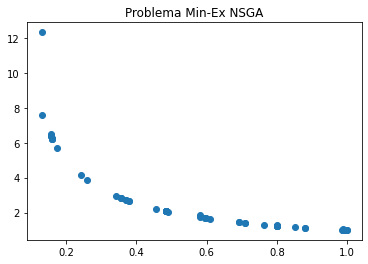

In [ ]:
 ### Cálculo da fit básica da nova geração
novagenReal = np.zeros((pop,nx))
Bin_xyzw_Real(novagen, novagenReal, pop, xmin, xmax)
Fit_fim = np.zeros((pop,nx), dtype=float)
fitnessMO(novagenReal, Fit_fim, pop)
print(Fit_fim[0:4])

fig1, ax1 = plt.subplots()
ax1.scatter(Fit_fim[:,0], Fit_fim[:,1])
plt.title('Problema Min-Ex NSGA')
plt.show()

# Funções: Max-Ex

In [ ]:
def f1(x1):
  return (1.1 - x1)

def f2(x1,x2):
  return (60 - ((1+x2)/x1))

def fitnessMO(vt_real, Fit, pop):
  for i in range(pop):
    Fit[i,0] = f1(vt_real[i][0])
    Fit[i,1] = f2(vt_real[i][0], vt_real[i][1])

def Dominando(Fit, vRank, pop):
  for i in range(pop):
    Fi1 = Fit[i,0]
    Fi2 = Fit[i,1]
    ni = 0
    for k in range(pop):
      if ((Fi1) < Fit[k,0]):    # Se é pior que um objetivo E
        if ((Fi2) < Fit[k,1]):  # Se é pior que o segundo objetivo
          ni += 1             # É dominada
    vRank[i] = ni + 1         # Atribui um rank


def Fdist(x,y, xmax, xmin):
  d = 0
  a = 0
  for i in range(nx):
    a += ( ( (x[i] - y[i])/(xmax[i] - xmin[i]) )**2)
  d = np.sqrt(a)
  return d

def nicho(d, alfaShare, alfa):
  if d <= alfaShare:
    f = 1 - (d/alfaShare)**alfa
  else:
    f = 0
  return f

# def sortir(vetor, vetorIndices, vetorSortido, elementos):
#   indices = (np.argsort(vetorIndices, axis=0))
#   i = 0
#   while i < elementos:
#     vetorSortido[i] = vetor[int(indices[i])]
#     i = i + 1

# def sortirMaior(vetor, vetorIndices, vetorSortido, elementos):
#   indices = (np.argsort(vetorIndices, axis=0))
#   i = 0
#   while i < elementos:
#     vetorSortido[i] = vetor[int(indices[i])]
#     i = i + 1
#   vetorSortido = vetorSortido[::-1]

In [ ]:
def sortir(vetor, vetorIndices, elementos):
  indices = (np.argsort(vetorIndices, axis=0))
  n = len(vetor[0])
  vetorSortido = np.zeros((elementos,n))
  i = 0
  while i < elementos:
    vetorSortido[i] = vetor[int(indices[i])]
    i = i + 1
  return vetorSortido

def sortirMaior(vetor, vetorIndices, elementos):
  indices = (np.argsort(vetorIndices, axis=0))
  n = len(vetor[0])
  vetorSortido = np.zeros((elementos,n))
  i = 0
  while i < elementos:
    vetorSortido[i] = vetor[int(indices[i])]
    i = i + 1
  return vetorSortido[::-1]

In [ ]:
# Etapa 3: Obter número total de ranks
def rankMembers(vRank_s):
  r_count = []    # Se não existe no vetor, anexa a ele
  for i in vRank_s:
    if (i not in r_count): r_count.append(i)  

  numRanks = len(r_count)

  memberCount = np.zeros((numRanks,2), dtype=int)

  Elem_contados = []
  n = 0
  for i in vRank_s:
    if i not in Elem_contados:
      Elem_contados.append(i)  # Anexado à lista de ranks únicos
      memberCount[n,0] = i
      memberCount[n,1] = list(vRank_s).count(i)
      n += 1

  return memberCount

In [ ]:
def Fitness_NSGA(vt_real_s, vRank_s, memberCount, limXY ,pop):
  dmatrix = np.zeros((pop,pop), dtype=float)
  nichomat = np.ones((pop,pop), dtype=float)
  nichoC = np.ones((pop,1), dtype=float)

  FitComp = pop*np.ones((pop,1))
  thisRank_Fit = F_min - epsilon

  for r in (memberCount[:,0]):
    # r = rankAtual
    for i in range(pop):          # Contador de posição
      if (vRank_s[i] == r):       # Confere se é o mesmo rank
        for k in range(pop):      # Coleta outro elemento
          if (i != k and (vRank_s[i] == vRank_s[k])): # Impede 1 com 1 e verifica outros do rank
            d = 0
            X1 = [vt_real_s[i,0],vt_real_s[i,1]]
            X2 = [vt_real_s[k,0],vt_real_s[k,1]] 
            d = Fdist(X1, X2, limXY[1], limXY[0])
            dmatrix[i,k] = d
            nichomat[i,k] = nicho(d,alfaShare,alfa)
            nichoC[i] += nichomat[i,k]  
          # Calcular a Fitness compartilhada
        FitComp[i] = thisRank_Fit/nichoC[i]
        #print(FitComp[i])
      # Antes de incrementar para o próximo rank:
    Fmin = np.min(FitComp)
    thisRank_Fit = Fmin - epsilon
    #print(thisRank_Fit)

  return FitComp

In [ ]:
def bin2real(b, xmin, xmax):
  # Conversão de inteiro para binário
  s = 0
  n = len(b)        # [s1,l] => Pega a dimensão 2
  for l in range(n):
    s = s + b[l]*pow(2,l)
  return xmin + (xmax - xmin)*s/(pow(2,n)-1)

In [ ]:
# Criar divisor de bits a serem usados!
def xj_range(bits, nx):
  limites_xj = np.zeros((2,nx), dtype=int)
  cont = 0
  ik = bits
  while ik <= (bits*nx):
    
    if ((ik) % bits == 0):    # Se ik for divisível por 20
      
      limites_xj[1,cont] = ik-1  # Atribui ub: 20, 40, 60, 80 (-1)
      cont = cont + 1            # incrementa
      if (cont < nx):
        limites_xj[0,cont] = ik # Atribui lb: 20, 40, 60 (-1)
      
    ik = ik + 1
  return limites_xj

In [ ]:
xj_range(20, 4)

array([[ 0, 20, 40, 60],
       [19, 39, 59, 79]])

In [ ]:
# Dividir X em nx parcelas de acordo com o limite em Xj_range
# Supondo X = vt[i,:]

def xj_divide(X, bits, nx):
  limites = xj_range(bits,nx)

  Xt = np.zeros((nx,bits), dtype=int)
  i = 0
  for i in range (nx):
    Xt[i,:] = X[limites[0,i]:(limites[1,i]+1)]
                                    # -> [0:19], python pega do 0 ao 18.
                                    # O +1 resolve o problema
  return Xt

In [ ]:
def criarpop(vetor, pop, cromo):
  i = 0
  for i in range(pop):                 # Cria-se uma linha(indivíduo) por vez
    n = (np.random.rand(1,cromo))      # Vetor randômico de números entre 0 e 1
    nr = np.around(n, 0)               # Arrendondam-se entre 0 e 1
    vetor[i,:] = nr[:]  

In [ ]:
def Bin_xyzw_Real(vetor_bin, vetor_real, pop, xmin, xmax):
  for i in range(pop):
    Xj = vetor_bin[i,:]              # Extrai um individuo da pop
    Xj_r = xj_divide(Xj, bits, nx)  # Leva para dividir nas N componentes dela (x,y,z,w)
                            # Passa cada componente para valor real
    Xj_r = np.transpose(Xj_r)
    k = 0
    for k in range (nx):
      vetor_real[i,k] = bin2real(Xj_r[:,k], xmin[k], xmax[k])

In [ ]:
def torneio(Fit_Especial,k):
  # Especial: Escalonada, compartilhada
  melhor_fitness = -1
  vencedor = -1
  for i in range(k):
    competidor = U.randint(0,len(Fit_Especial)-1)
    if Fit_Especial[competidor] > melhor_fitness:
      melhor_fitness = Fit_Especial[competidor]
      vencedor = competidor
  return vencedor

In [ ]:
# Deprecado. Esconde os vetor_sortido do código.

def NSGA(modo):
  print('Problema: ' + modo)
  Dominando(Fit, vRank, pop)
 
  vRank_s = sortir(vRank, vRank, pop)
  vt_real_s = sortir(vt_real, vRank, pop)
  vt_bin_s = sortir(vt_bin, vRank, pop)
  Fit_s = sortir(Fit, vRank, pop)

  # Etapa 1: Número de ranks e membros por rank
  memberCount = rankMembers(vRank_s)

  FitComp = Fitness_NSGA(vt_real_s, vRank_s, memberCount, limXY , pop)
  return [FitComp, memberCount]

In [ ]:
def selecao_maximizar(FitComp, pop):
  i_selecionados = np.zeros((pop,1), dtype=int)
  for k in range(pop):
    i_selecionados[k] = torneio(FitComp, 3)
  return i_selecionados

In [ ]:
def criaPares(pop, indicesSelec):
  vetor_pares = np.zeros((pop,2), dtype=int) # Indices dos pares 
  for p in range(pop):   # Preencher todos os filhos
    for k in range(2):              # Escolher 2 dos selecionados de forma randomica
      r = int(np.floor(pop*(U.random())))
      vetor_pares[p,k] = indicesSelec[r]
  return vetor_pares

In [ ]:
def cruzamentoUmPonto(P_1, P_2, Filho):  # Crossover de 1 ponto
  # Gerar máscara
  m = int(np.floor(cromo*U.random()))   # Gera num entre 0 e cromo
  Filho[0:m] = P_1[0:m]
  Filho[m:cromo] = P_2[m:cromo]

  return Filho

In [ ]:
def cruzamento(vetor_bin_S, indice_pares, filhos, Px):
  for i in range(pop):
    r = U.random()  # Porcentagem de crossover
    if (r <= Px):
      P_1 = vetor_bin_S[indice_pares[i,0]]
      P_2 = vetor_bin_S[indice_pares[i,1]]
      filhos[i,:] = cruzamentoUmPonto(P_1, P_2, filhos[i,:])
    else:
      filhos[i,:] = vetor_bin_S[indice_pares[i,0]]
  # Se não tiver crossover, ele simplesmente deixa o filho como estava.

In [ ]:
# Taxa de mutação: Pm = 0.02
def mutacao(filho, cromo, Pm):
  for i in range(cromo):
    r = U.random()    # Porcentagem de crossover
    if (r < Pm):     
      filho[i] = int(not filho[i]) # Inversão com porta NOT, depois converte pra int
  return filho

# Loop - NSGA binario p/ Max-Ex

In [ ]:
# Parâmetros AG bin
pop = 60
MaxGen = 100
filhospop = int(pop*0.8)
doupop = int(pop*2)
bits = 40
nx = 2
cromo = bits*nx
Px = 0.95
Pm = 0.02

limXY =  [[0.1, 0],    # X, Y   # Min
          [1  , 5]]             # Max
xmin = limXY[0]
xmax = limXY[1]

# Criação de vetores
vt_bin = np.zeros((pop, cromo), dtype=int)
vt_real = np.zeros((pop, nx), dtype=float)
Fit = np.zeros((pop,2))
vRank = np.zeros((pop,1), dtype=int)

filhos = np.zeros((pop, cromo), dtype=int)
fi_real = np.zeros((pop, nx), dtype=float)
fi_Fit = np.zeros((pop,2))
fi_Rank = np.zeros((pop,1), dtype=int)


dmatrix = np.zeros((pop,pop), dtype=float)
nichomat = np.ones((pop,pop), dtype=float)
nichoC = np.ones((pop,1), dtype=float)

In [ ]:
# Parâmetros NSGA
alfa = 2
alfaShare = 0.12
epsilon = 0.1
F_min = pop + epsilon

# Inicialização
criarpop(vt_bin, pop, cromo)
print(vt_bin[0:3,:])


# Conversão em Real e Cálculo de Fitness
Bin_xyzw_Real(vt_bin, vt_real, pop, xmin, xmax)

# Calculo da fit
fitnessMO(vt_real, Fit, pop)

print(Fit[0:3,:])

[[0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1
  1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0
  1 0 0 1 0 0 0 0]
 [1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0
  1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1
  0 1 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0
  0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1
  0 0 1 1 1 1 0 0]]
[[ 0.5683347  57.77511524]
 [ 0.92469265 53.08808036]
 [ 0.53479523 56.12441934]]


In [ ]:
#MaxGen = 300
# Temos vt_bin inicializado
for i in range(MaxGen):
  
  ### Fitness dos valores Reais
  Bin_xyzw_Real(vt_bin, vt_real, pop, xmin, xmax)
  fitnessMO(vt_real, Fit, pop)
  Dominando(Fit, vRank, pop)

  vRank_s = sortir(vRank, vRank, pop)
  vt_real_s = sortir(vt_real, vRank, pop)
  vt_bin_s = sortir(vt_bin, vRank, pop)
  Fit_s = sortir(Fit, vRank, pop)

  vt_bin_s = vt_bin_s.astype(int)
  vRank_s = vRank_s.astype(int)

  # Número de ranks e membros por rank e Fit compartilhada
  memberCount = rankMembers(vRank_s)
  FitComp = Fitness_NSGA(vt_real_s, vRank_s, memberCount, limXY , pop)

  ### Algoritmo Genético binário
  iSelecionados = selecao_maximizar(FitComp, pop) # Seleção
  paresRep = criaPares(pop, iSelecionados)
  cruzamento(vt_bin_s, paresRep, filhos, Px)      # Crossover
  for i in range(pop):                          
    filhos[i,:] = mutacao(filhos[i,:],cromo,Pm)   # Mutação 
  
  ### Calcular Fit dos filhos
  Bin_xyzw_Real(filhos, fi_real, pop, xmin, xmax)
  fitnessMO(fi_real, fi_Fit, pop)

  Dominando(fi_Fit, fi_Rank, pop)

  fi_Rank_s = sortir(fi_Rank, fi_Rank, pop)
  fi_real_s = sortir(fi_real, fi_Rank, pop)
  filhos_s = sortir(filhos, fi_Rank, pop)
  fi_Fit_s = sortir(fi_Fit, fi_Rank, pop)

  filhos_s = filhos_s.astype(int)
  fi_Rank_s = fi_Rank_s.astype(int)

  # Número de ranks e membros por rank, fitness compartilhada
  filhosCount = rankMembers(fi_Rank_s)
  fi_FitComp = Fitness_NSGA(fi_real_s, fi_Rank_s, filhosCount, limXY , pop)

  ### Atualizar população

  novagen = np.zeros((pop, cromo), dtype=int)

  FitComp_filhos = np.copy(fi_FitComp)
  filhosSortidos = np.copy(filhos_s)
  FitComp_pop = np.copy(FitComp)
  popSortidos = np.copy(vt_bin_s)

  # 20% dos pais
  # 80% dos filhos
  for i in range(pop):
    if i < (filhospop): 
      ik = torneio(FitComp_filhos, 3)
      novagen[i,:] = filhosSortidos[ik,:]
      FitComp_filhos = np.delete(FitComp_filhos,ik, axis=0)
      filhosSortidos = np.delete(filhosSortidos,ik, axis=0)
    if i >= (filhospop):
      ik = torneio(FitComp_pop, 4)
      novagen[i,:] = popSortidos[ik,:]
      FitComp_pop = np.delete(FitComp_pop,ik, axis=0)
      popSortidos = np.delete(popSortidos,ik, axis=0)

  # print(novagen[0:4])
  # print(novagen[pop-4:pop])

  # Atribui novo valor e reinicia
  vt_bin = novagen


[[ 0.54646369 58.19096954]
 [ 0.43727375 58.49086508]
 [ 0.21072837 58.87540564]
 [ 0.43727365 58.49086532]]


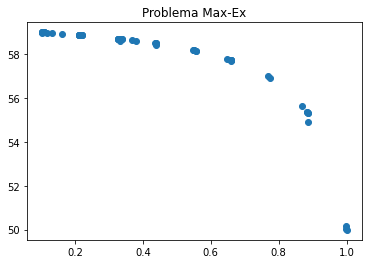

In [ ]:
 ### Cálculo da fit básica da nova geração
novagenReal = np.zeros((pop,nx))
Bin_xyzw_Real(novagen, novagenReal, pop, xmin, xmax)
Fit_fim = np.zeros((pop,nx), dtype=float)
fitnessMO(novagenReal, Fit_fim, pop)
print(Fit_fim[0:4])

fig1, ax1 = plt.subplots()
ax1.scatter(Fit_fim[:,0], Fit_fim[:,1])
plt.title('Problema Max-Ex')
plt.show()